In [2]:
# force geopandas to use shapely instead of pygeos
import os
os.environ['USE_PYGEOS'] = '0'

import numpy as np
import pandas as pd
import plotly.express as px
from shapely import wkt
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [46]:
# datetime manipulation helper functions

def filter_by_date_range(df: pd.DataFrame, column_name: str, start_string: str, end_string: str):
    return df[(df[column_name] >= pd.Timestamp(start_string)) & (df[column_name] <= pd.Timestamp(end_string))]

In [3]:
meters = pd.read_csv("../data/Parking_Meters.csv")

In [4]:
meters['shape'] = meters['shape'].apply(wkt.loads)
meters = gpd.GeoDataFrame(meters, geometry='shape')
meters.crs = 'EPSG:4326'

street_df = pd.read_csv('../data/street_sweeping.csv')
street_df = street_df[~street_df.Line.isnull()]
street_df.loc[:, 'Line'] = street_df.Line.apply(wkt.loads)
street_df = gpd.GeoDataFrame(street_df, geometry='Line')
street_df.crs = 'EPSG:4326'

unique_streets = street_df.drop_duplicates(subset='Line')

In [5]:
# filter to only include active meters

active = meters[(meters["ACTIVE_METER_FLAG"] == "M") | (meters["ACTIVE_METER_FLAG"] == "T")]

In [6]:
active.shape

(29313, 45)

In [7]:
# joins active meters to street

joined = gpd.sjoin_nearest(active, unique_streets, distance_col='dist', how='left')
joined.shape

/Users/tessa/opt/anaconda3/envs/stat-222/lib/python3.9/site-packages/geopandas/array.py:344: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


(29334, 63)

In [8]:
joined['street_id'] = joined['Corridor'] + ' ' + joined['Limits']

In [11]:
# how many meters on each street

joined['street_id'].value_counts()

Channel Start: 601-698 Block  -  End: 601-698 Block      172
Illinois St 16th St  -  Mariposa St                      167
Mission Bay Blvd North erry A Francois Blvd - Vara St    129
Bluxome St 04th St  -  05th St                           126
Main St Market St  -  Mission St                         110
                                                        ... 
Cleveland St Sherman St  -  07th St                        1
Vallejo St Battery St  -  Cowell Pl                        1
21st St Valencia St  -  Guerrero St                        1
Cortland Ave Mission St  -  Coleridge St                   1
Sansome St Merchant St  -  Washington St                   1
Name: street_id, Length: 2113, dtype: int64

In [41]:
joined[joined['street_id'] == 'The Embarcadero Washington St  -  Broadway']['POST_ID'].nunique()

34

In [12]:
# transaction data 54 seconds

pay = pd.read_parquet("../data/meter_data_2022.parquet")

In [13]:
pay.head()

,TRANSMISSION_DATETIME,POST_ID,STREET_BLOCK,PAYMENT_TYPE,SESSION_START_DT,SESSION_END_DT,METER_EVENT_TYPE,GROSS_PAID_AMT
45536904,222408714_4_01012022002410,831-02200,EMBARCADERO SOUTH 200,CASH,2022/01/01 12:24:10 AM,2022/01/01 12:24:10 AM,NS,1.50
45536905,222408715_4_01012022003157,546-28060,LEAVENWORTH ST 2800,CASH,2022/01/01 12:31:57 AM,2022/01/01 12:31:57 AM,NS,0.50
45536906,222408723_4_01012022011253,830-03290,EMBARCADERO NORTH 300,CASH,2022/01/01 01:12:53 AM,2022/01/01 01:12:53 AM,NS,0.50
45536907,222408728_4_01012022020117,336-14220,BUSH ST 1400,CASH,2022/01/01 02:01:17 AM,2022/01/01 02:01:17 AM,NS,0.25
45536908,222408729_4_01012022022638,568-05550,MISSION ST 500,CASH,2022/01/01 02:26:38 AM,2022/01/01 02:26:38 AM,NS,1.00


In [14]:
# 36 seconds

df = pd.merge(pay, joined, on='POST_ID')

In [87]:
df.head()

,TRANSMISSION_DATETIME,POST_ID,STREET_BLOCK,PAYMENT_TYPE,SESSION_START_DT,SESSION_END_DT,METER_EVENT_TYPE,GROSS_PAID_AMT,OBJECTID,PARKING_SPACE_ID,...,ToHour,Week1,Week2,Week3,Week4,Week5,Holidays,BlockSweepID,dist,street_id
0,222408714_4_01012022002410,831-02200,EMBARCADERO SOUTH 200,CASH,2022/01/01 12:24:10 AM,2022/01/01 12:24:10 AM,NS,1.50,5272708,0,...,3,1,1,1,1,1,1,1639572,0.000097,The Embarcadero Folsom St - Howard St
1,222412313_4_01022022121822,831-02200,EMBARCADERO SOUTH 200,CREDIT CARD,2022/01/02 12:18:22 PM,2022/01/02 01:18:22 PM,NS,8.00,5272708,0,...,3,1,1,1,1,1,1,1639572,0.000097,The Embarcadero Folsom St - Howard St
2,222412993_4_01022022135210,831-02200,EMBARCADERO SOUTH 200,CREDIT CARD,2022/01/02 01:52:10 PM,2022/01/02 03:52:17 PM,NS,14.49,5272708,0,...,3,1,1,1,1,1,1,1639572,0.000097,The Embarcadero Folsom St - Howard St
3,222448944_4_01032022140304,831-02200,EMBARCADERO SOUTH 200,CREDIT CARD,2022/01/03 02:03:04 PM,2022/01/03 04:23:28 PM,NS,9.06,5272708,0,...,3,1,1,1,1,1,1,1639572,0.000097,The Embarcadero Folsom St - Howard St
4,832929888_9_01032022180700,831-02200,EMBARCADERO SOUTH 200,PAY BY CELL,2022/01/03 06:07:00 PM,2022/01/03 08:07:00 PM,NS,4.00,5272708,0,...,3,1,1,1,1,1,1,1639572,0.000097,The Embarcadero Folsom St - Howard St


In [15]:
cols_to_keep = ['POST_ID', 'SESSION_START_DT', 'SESSION_END_DT', 'street_id']
df = df[cols_to_keep]

In [16]:
df.street_id

0           The Embarcadero Folsom St  -  Howard St
1           The Embarcadero Folsom St  -  Howard St
2           The Embarcadero Folsom St  -  Howard St
3           The Embarcadero Folsom St  -  Howard St
4           The Embarcadero Folsom St  -  Howard St
                             ...                   
19093804           Geary Blvd 16th Ave  -  17th Ave
19093805           Geary Blvd 16th Ave  -  17th Ave
19093806           Geary Blvd 16th Ave  -  17th Ave
19093807           Geary Blvd 16th Ave  -  17th Ave
19093808            Gough St Linden St  -  Hayes St
Name: street_id, Length: 19093809, dtype: object

In [38]:
# for one area only

df = df[df.street_id == 'The Embarcadero Washington St  -  Broadway']
df.shape

(46903, 4)

In [19]:
# filter out prepaid meters
# 1 minute

df = df[df.SESSION_START_DT != df.SESSION_END_DT]

In [20]:
# change start and end times to datetime
# 92 minutes

df.SESSION_START_DT = pd.to_datetime(df.SESSION_START_DT)
df.SESSION_END_DT = pd.to_datetime(df.SESSION_END_DT)

In [56]:
df

,POST_ID,SESSION_START_DT,SESSION_END_DT,street_id
3342,830-03290,2022-01-02 07:36:00,2022-01-02 07:48:30,The Embarcadero Washington St - Broadway
3343,830-03290,2022-01-02 17:32:28,2022-01-02 17:37:05,The Embarcadero Washington St - Broadway
3344,830-03290,2022-01-02 17:33:47,2022-01-02 19:09:10,The Embarcadero Washington St - Broadway
3345,830-03290,2022-01-02 09:01:00,2022-01-02 16:01:00,The Embarcadero Washington St - Broadway
3346,830-03290,2022-01-02 16:01:00,2022-01-02 17:01:00,The Embarcadero Washington St - Broadway
...,...,...,...,...
18254282,830-02910,2022-12-31 12:27:00,2022-12-31 12:57:00,The Embarcadero Washington St - Broadway
18254283,830-02910,2022-12-31 16:22:53,2022-12-31 17:07:53,The Embarcadero Washington St - Broadway
18254284,830-02910,2022-12-31 12:45:13,2022-12-31 14:29:42,The Embarcadero Washington St - Broadway
18254285,830-02910,2022-12-31 14:52:48,2022-12-31 16:14:36,The Embarcadero Washington St - Broadway


In [21]:
dic = dict()
for column in df.columns:
    if column == 'SESSION_START_DT':
        dic[column] = "min"
    elif column == 'SESSION_END_DT':
        dic[column] = "max"
    else:
        dic[column] = "first"

In [22]:
# merge rows where meter transactions were within 3 mins

def merge_overlapping_rows(df):
    # initialize the group column
    df['group'] = 0
    df = df.sort_values("SESSION_START_DT").reset_index(drop = True)

    # initialize variables for the current group number and end time
    group_num = 0
    prev_end_time = df.loc[0, 'SESSION_END_DT']

    # loop over the rows and assign group numbers
    for i in range(1, len(df)):
        if df.loc[i, 'SESSION_START_DT'] >= (prev_end_time + pd.Timedelta(minutes=3)):
            # new interval, increment group number and update previous end time
            group_num += 1
            prev_end_time = df.loc[i, 'SESSION_END_DT']
            df.loc[i, 'group'] = group_num
        else:
            # overlapping interval, assign the same group number and update previous end time
            df.loc[i, 'group'] = group_num
            prev_end_time = max(prev_end_time, df.loc[i, 'SESSION_END_DT'])

    # group by the group column and aggregate the start and end times
    result = df.groupby('group').agg(dic).reset_index(drop=True)

    return result

In [42]:
# 34 mins

temp = df.groupby("POST_ID").apply(merge_overlapping_rows)

In [57]:
temp

POST_ID    SESSION_START_DT      SESSION_END_DT  \
POST_ID                                                            
830-02840 0    830-02840 2022-01-02 08:05:35 2022-01-02 08:16:11   
          1    830-02840 2022-01-02 11:11:00 2022-01-02 12:11:00   
          2    830-02840 2022-01-02 12:33:41 2022-01-02 19:36:00   
          3    830-02840 2022-01-02 19:57:34 2022-01-02 21:03:34   
          4    830-02840 2022-01-03 08:38:09 2022-01-03 09:08:09   
...                  ...                 ...                 ...   
830-04330 948  830-04330 2022-12-30 11:06:09 2022-12-30 13:38:43   
          949  830-04330 2022-12-30 14:26:00 2022-12-30 17:26:34   
          950  830-04330 2022-12-30 17:37:55 2022-12-30 19:38:12   
          951  830-04330 2022-12-31 16:16:28 2022-12-31 16:24:48   
          952  830-04330 2022-12-31 18:22:20 2022-12-31 19:14:50   

                                                street_id  
POST_ID                                                    
830-02840 0    The Embarcadero Washington St  -  Broadway  
          1    The Embarcadero Washington St  -  Broadway  
          2    The Embarcadero Washington St  -  Broadway  
          3    The Embarcadero Washington St  -  Broadway  
          4    The Embarcadero Washington St  -  Broadway  
...                                                   ...  
830-04330 948  The Embarcadero Washington St  -  Broadway  
          949  The Embarcadero Washington St  -  Broadway  
          950  The Embarcadero Washington St  -  Broadway  
          951  The Embarcadero Washington St  -  Broadway  
          952  The Embarcadero Washington St  -  Broadway  

[26626 rows x 4 columns]

In [49]:
one_date = filter_by_date_range(df, 'SESSION_START_DT', '1-02-2022', '1-03-2022')

In [51]:
one_date.shape

(148, 4)

In [53]:
one_date.sort_values('SESSION_START_DT')

,POST_ID,SESSION_START_DT,SESSION_END_DT,street_id
693946,830-04030,2022-01-02 06:27:45,2022-01-02 07:31:46,The Embarcadero Washington St - Broadway
1783722,830-04070,2022-01-02 07:02:49,2022-01-02 08:02:49,The Embarcadero Washington St - Broadway
3342,830-03290,2022-01-02 07:36:00,2022-01-02 07:48:30,The Embarcadero Washington St - Broadway
2284072,830-04330,2022-01-02 07:53:00,2022-01-02 08:53:00,The Embarcadero Washington St - Broadway
1787363,830-04170,2022-01-02 07:53:14,2022-01-02 08:53:14,The Embarcadero Washington St - Broadway
...,...,...,...,...
1783725,830-04070,2022-01-02 21:37:25,2022-01-02 21:38:10,The Embarcadero Washington St - Broadway
1783729,830-04070,2022-01-02 21:38:10,2022-01-02 22:15:40,The Embarcadero Washington St - Broadway
1783726,830-04070,2022-01-02 21:38:25,2022-01-02 22:20:10,The Embarcadero Washington St - Broadway
1783727,830-04070,2022-01-02 21:38:49,2022-01-02 22:25:25,The Embarcadero Washington St - Broadway


In [55]:
fig = px.timeline(one_date[one_date.POST_ID == '830-04070'].sort_values('SESSION_START_DT'), x_start="SESSION_START_DT", x_end="SESSION_END_DT")
fig.update_yaxes(autorange="reversed") # otherwise tasks are listed from the bottom up
fig.show()

In [24]:
# replaces datetime with datetime + 15 mins

def create_interval_endpoint(start_time, td):
    new_time = start_time.replace(hour=0, minute=0, second=0, microsecond=0) + td
    return new_time

In [25]:
# creates list of 36 intervals, where each element is a column = boolean where True means paid for the entire interval
# 73 minutes

interval_series = []


for i in range(9*4, 18*4):
    start_time_diff = datetime.timedelta(minutes = (i*15))  # time difference of 15 minutes
    end_time_diff = datetime.timedelta(minutes = ((i + 1)*15))  # time difference of 15 minutes
    start_times = temp.SESSION_START_DT.apply(lambda start_time: create_interval_endpoint(start_time, start_time_diff))
    end_times = temp.SESSION_START_DT.apply(lambda end_time: create_interval_endpoint(end_time, end_time_diff))

    interval_series.append((temp['SESSION_START_DT'] <= start_times) & (temp['SESSION_END_DT'] >= end_times))


In [26]:
len(interval_series)

36

In [19]:
# 60 mins

int_ser = pd.DataFrame(interval_series)
int_ser.to_csv('../data/intervals2.csv', index=False)
temp.to_csv('../data/temp.csv', index=False)

In [102]:
temp.columns

Index(['POST_ID', 'SESSION_START_DT', 'SESSION_END_DT', 'street_id'], dtype='object')

In [80]:
temp.STREET_ID

POST_ID      
102-02990  0     102.0
           1     102.0
           2     102.0
           3     102.0
           4     102.0
                 ...  
923-00260  34    690.0
           35    690.0
           36    690.0
           37    690.0
           38    690.0
Name: STREET_ID, Length: 12776566, dtype: float64

In [27]:
# columns: 36 for intervals; session start date, street
session_start_date = pd.to_datetime(temp.SESSION_START_DT.dt.date)
street = temp.street_id
final_df = pd.concat(interval_series + [session_start_date, street], axis=1)

In [28]:
tmp = pd.concat(interval_series, axis=1)

In [29]:
# checks to see if there is at least one unpaid meter and collapses rows

def count_infractions(df):
    return ~(~df).any()

collapsed_df = final_df.groupby(["SESSION_START_DT", "street_id"]).apply(count_infractions).reset_index()

In [30]:

collapsed_df["weekday"] = collapsed_df.SESSION_START_DT.dt.day_name()

final_final_df = collapsed_df.groupby(["street_id", "weekday"]).sum()


/var/folders/b7/y91htkqs5jn2g1znl4ghlk1r0000gn/T/ipykernel_1727/1854478100.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  final_final_df = collapsed_df.groupby(["street_id", "weekday"]).sum()


In [33]:
df['street_id'].unique()

array(['The Embarcadero Folsom St  -  Howard St',
       'The Embarcadero Washington St  -  Broadway',
       'The Embarcadero Brannan St  -  Bryant St',
       'Brannan St The Embarcadero  -  Delancey St',
       'The Embarcadero Townsend St  -  Brannan St',
       'Broadway The Embarcadero  -  Davis St',
       'The Embarcadero Don Chee Way  -  Washington St',
       'Powell St Beach St  -  The Embarcadero',
       'The Embarcadero Green St  -  Lombard St',
       'Washington St The Embarcadero  -  Drumm St',
       'North Point St The Embarcadero  -  Grant Ave',
       'Townsend St The Embarcadero  -  Colin P Kelly Jr St',
       'The Embarcadero Chestnut St  -  Bay St',
       'The Embarcadero Bryant St  -  Harrison St',
       'King St The Embarcadero  -  02nd St',
       'The Embarcadero Broadway  -  Green St',
       'Grant Ave North Point St  -  The Embarcadero',
       'Chestnut St The Embarcadero  -  Montgomery St',
       'The Embarcadero Mission St  -  Washington St',
     

In [31]:
joined['street_id'].value_counts().index[0]

'Channel Start: 601-698 Block  -  End: 601-698 Block'

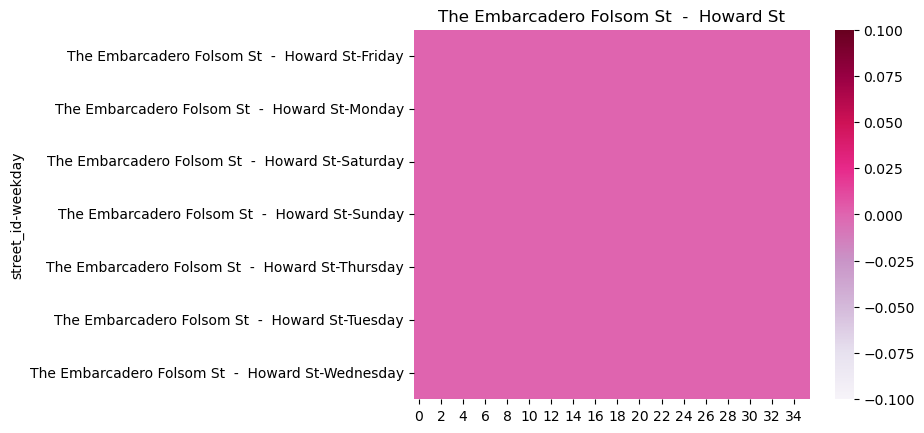

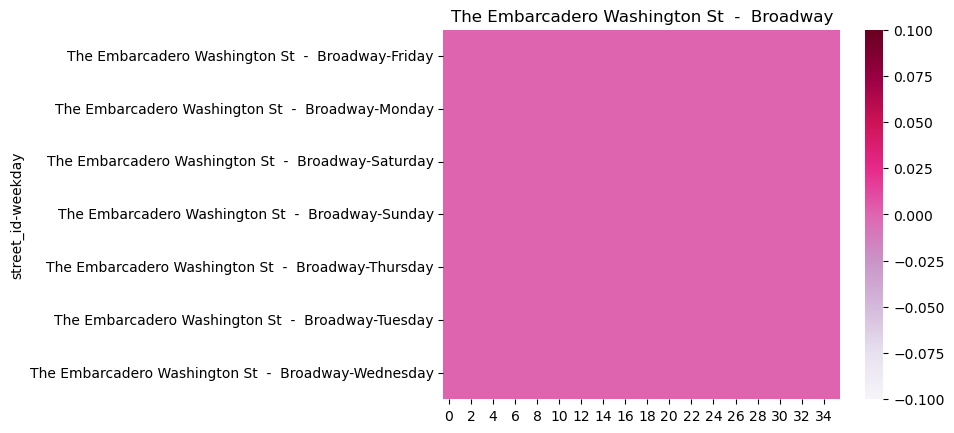

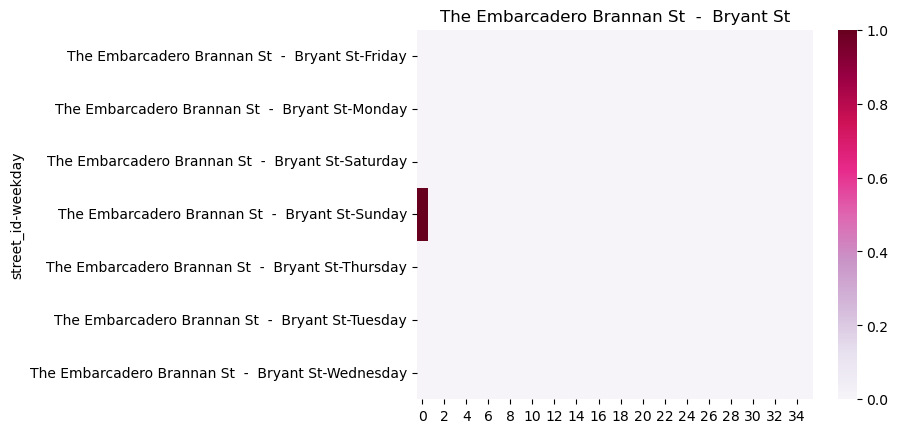

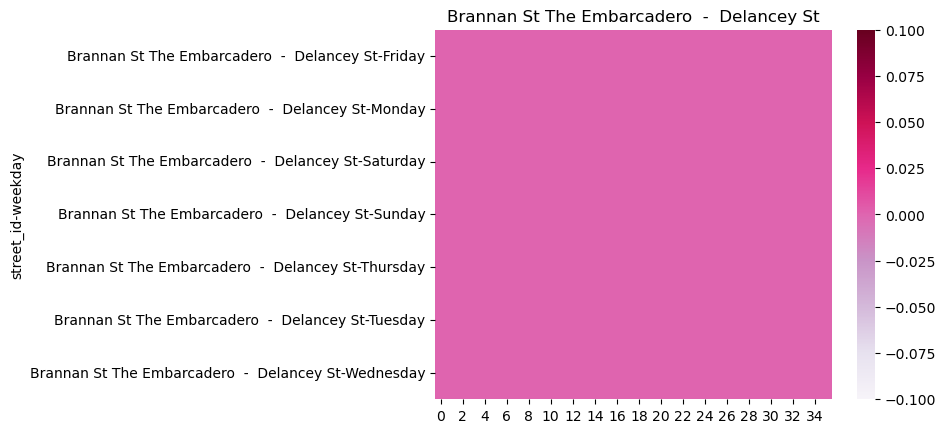

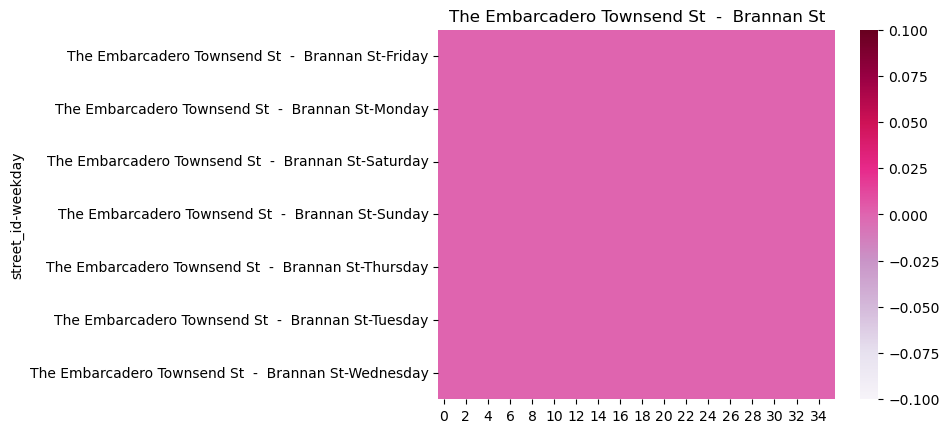

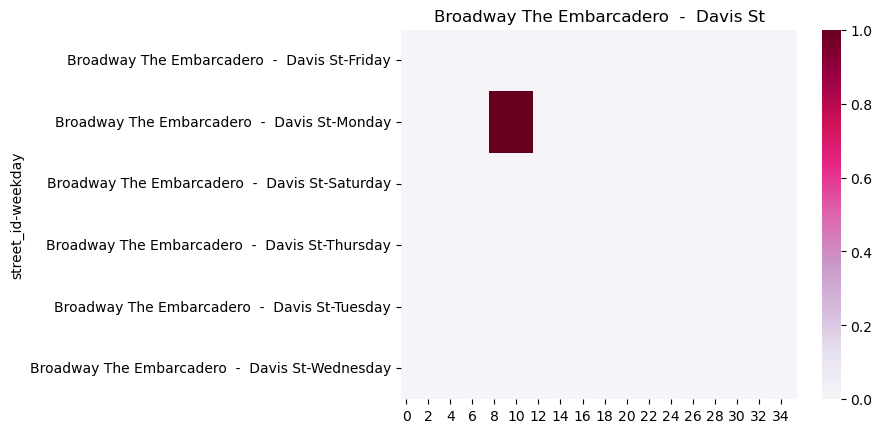

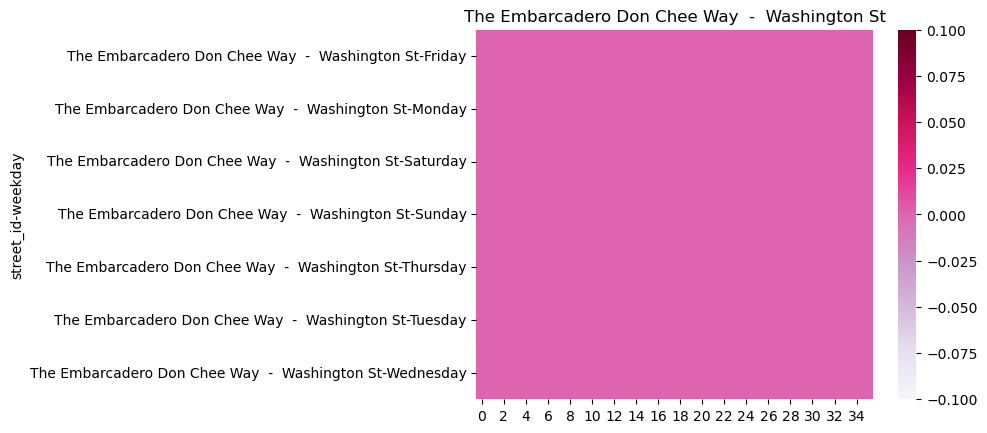

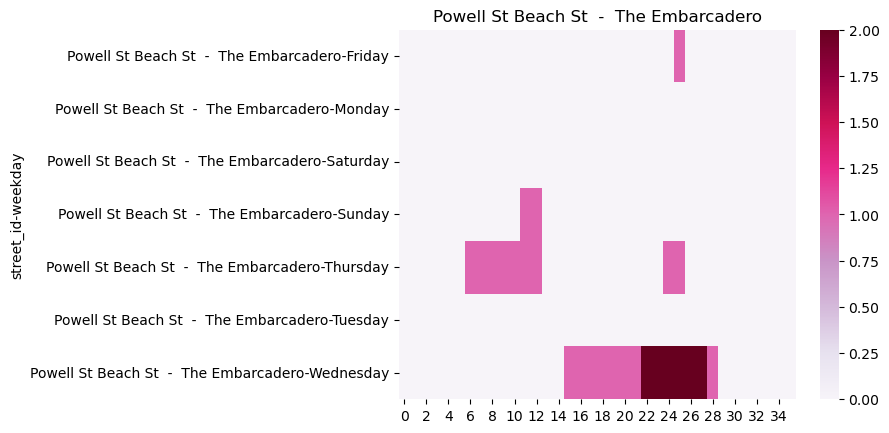

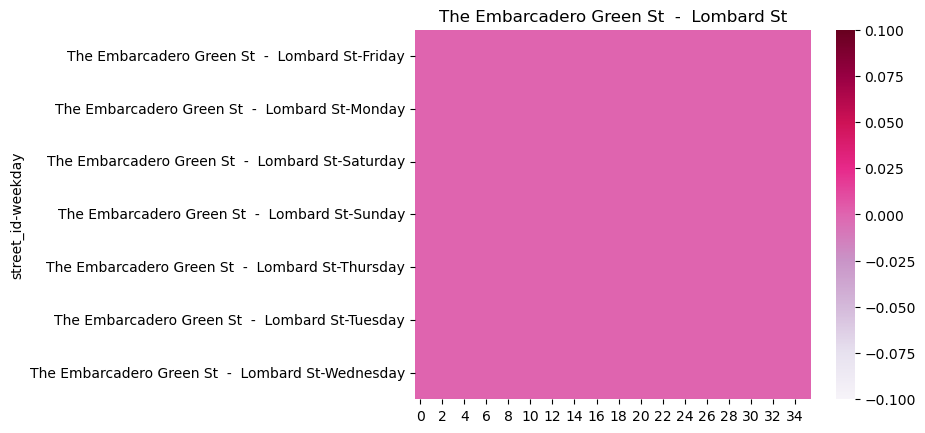

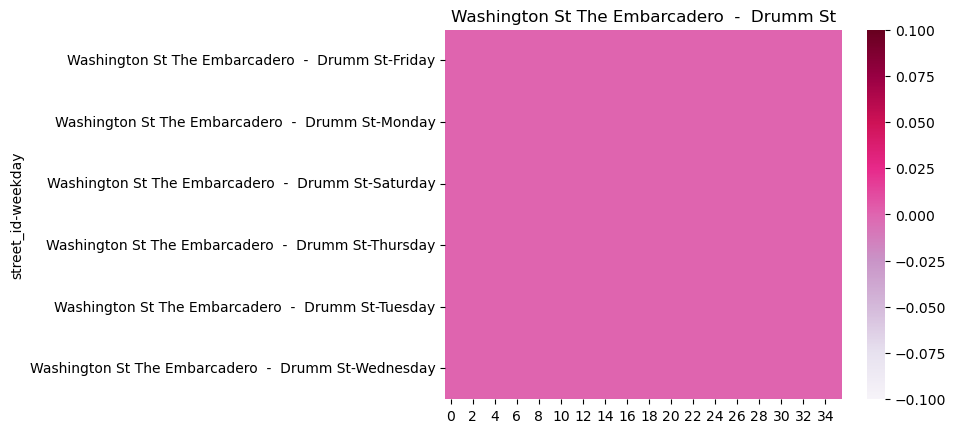

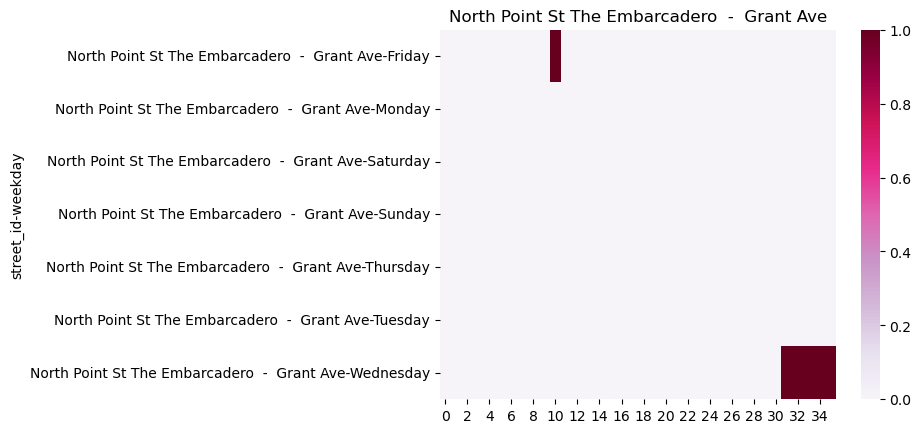

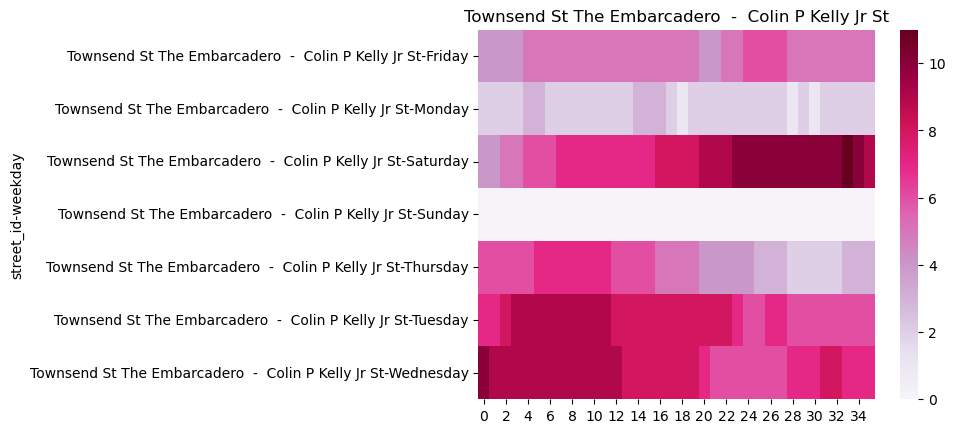

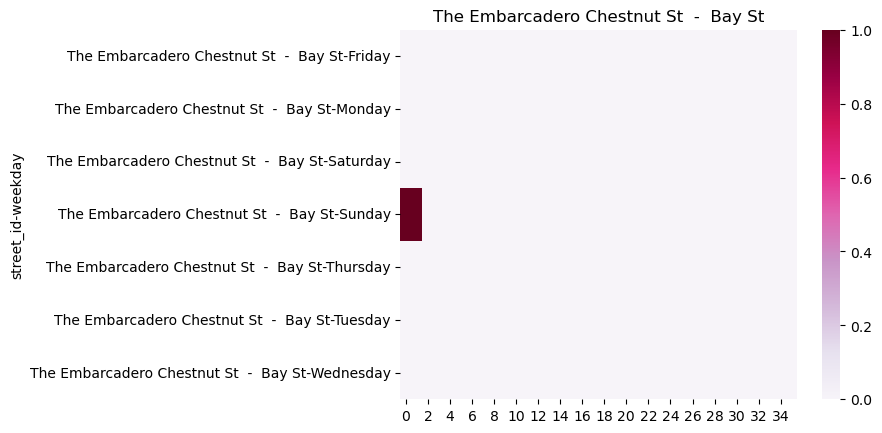

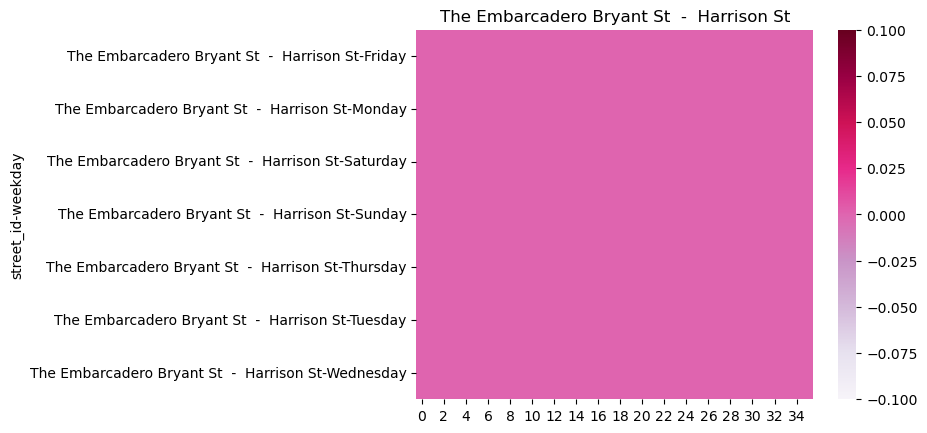

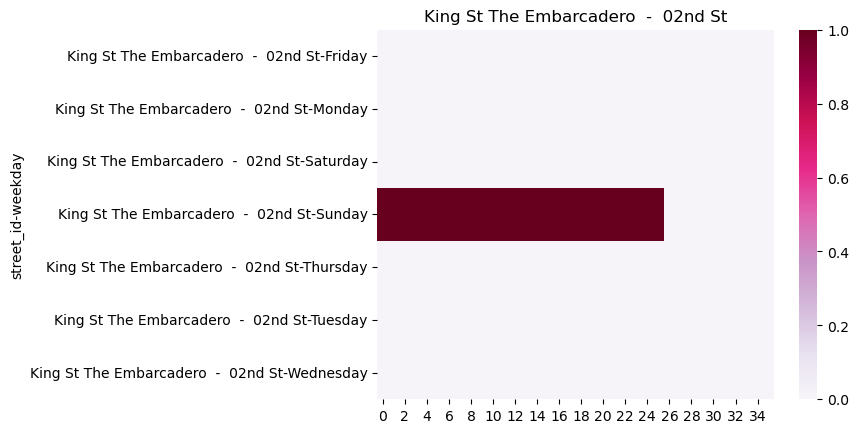

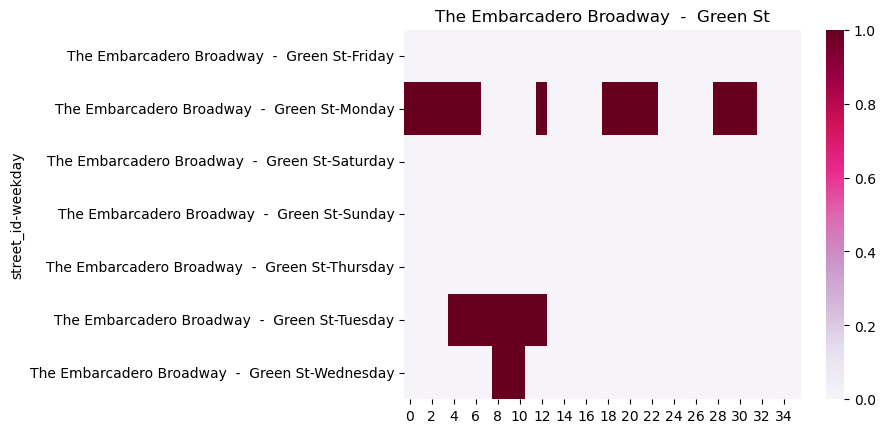

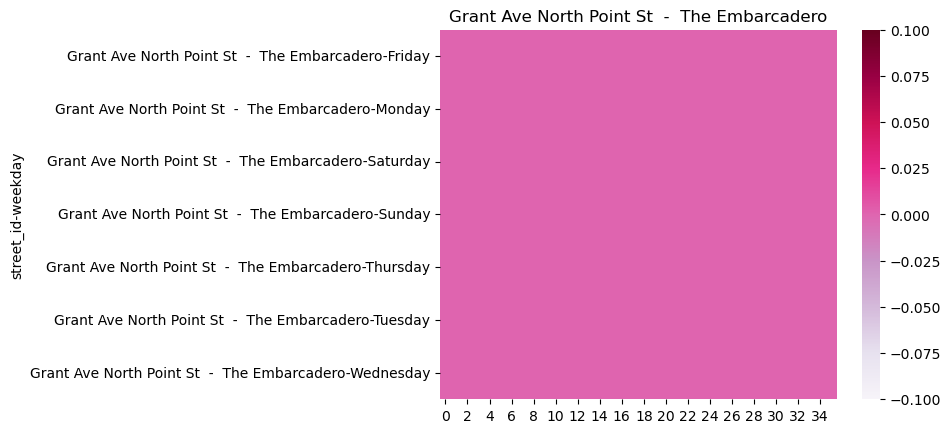

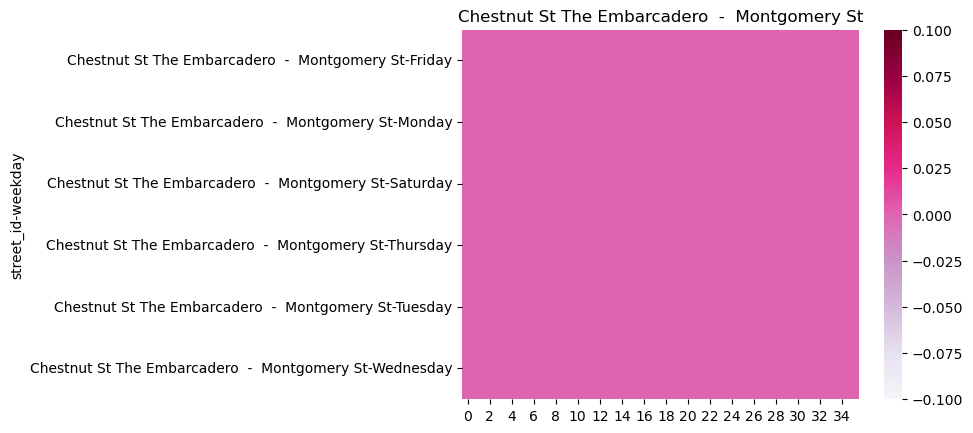

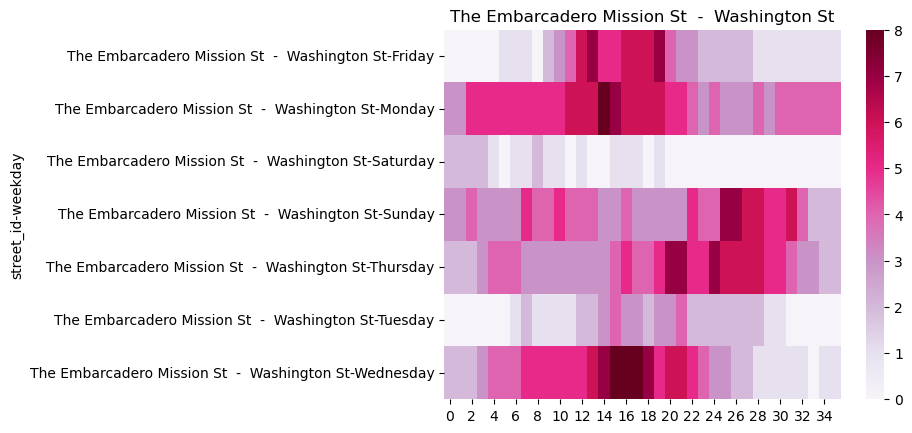

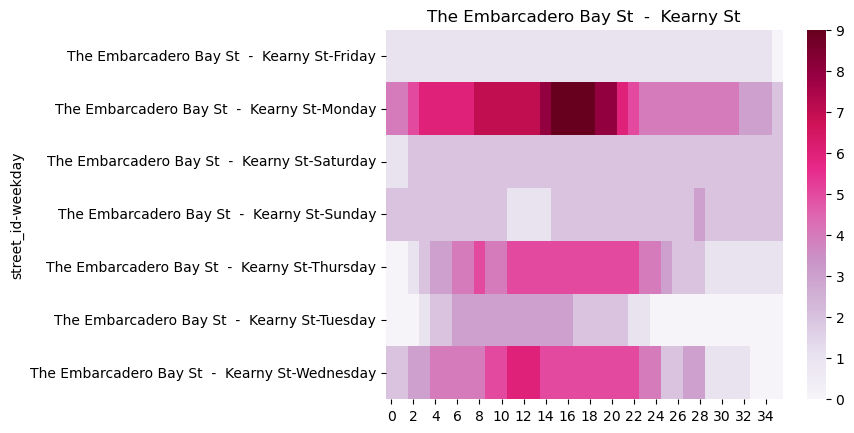

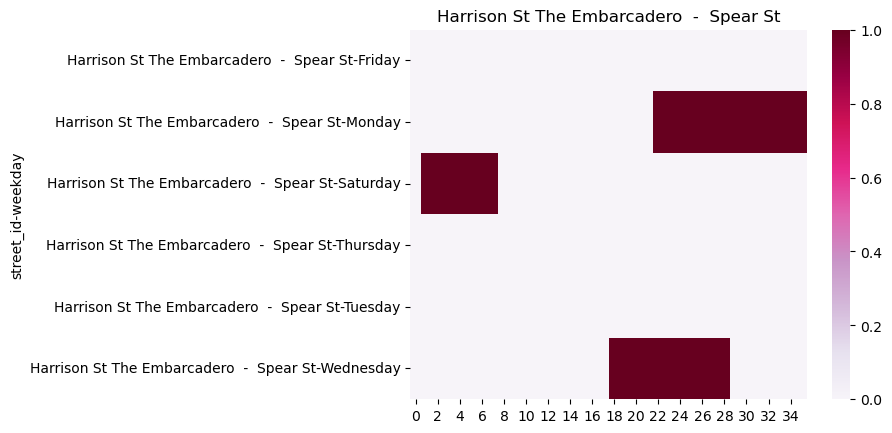

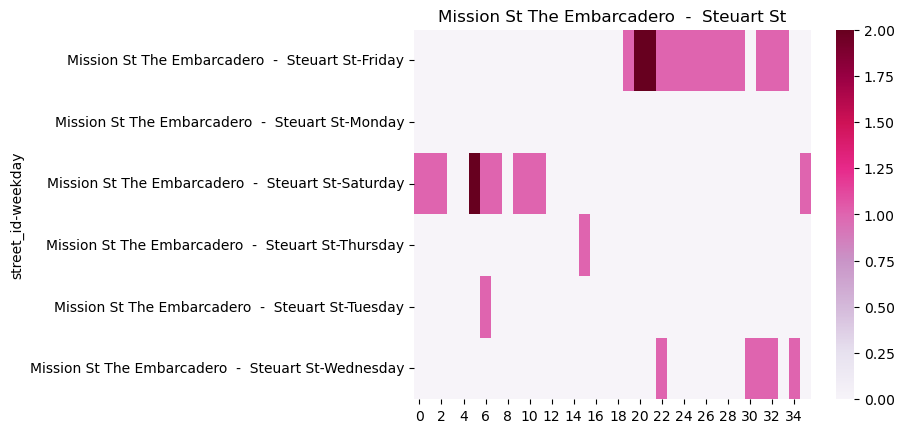

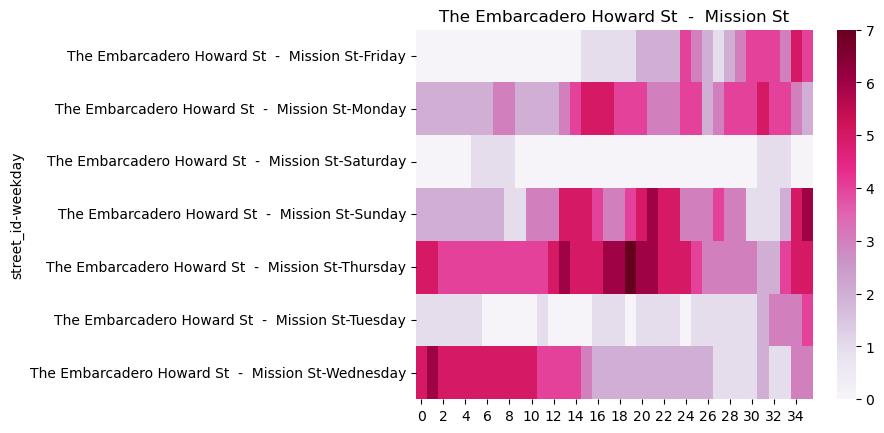

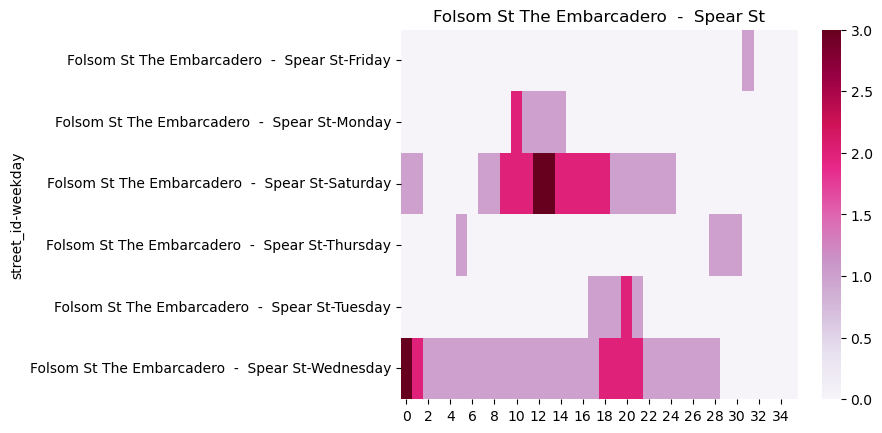

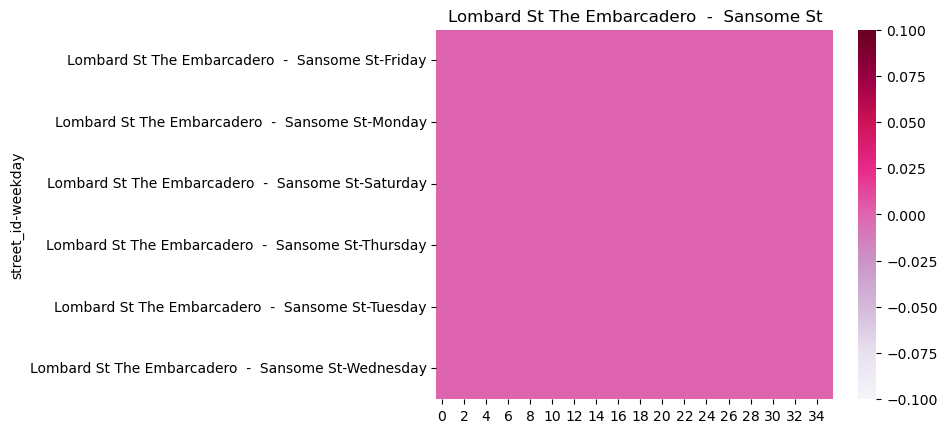

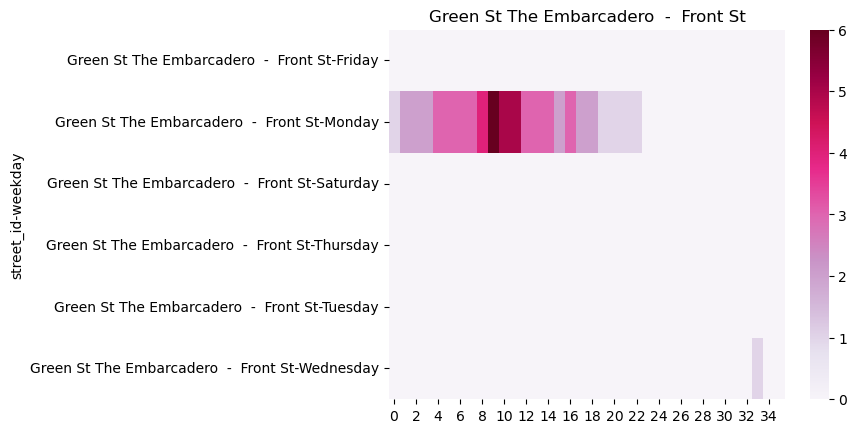

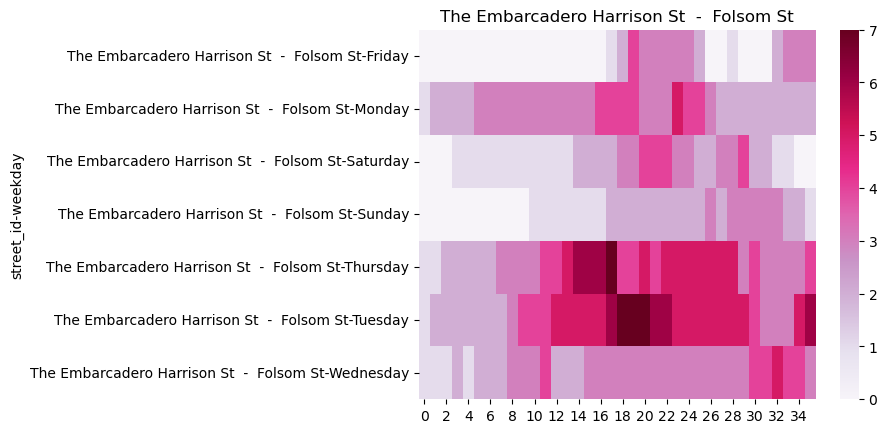

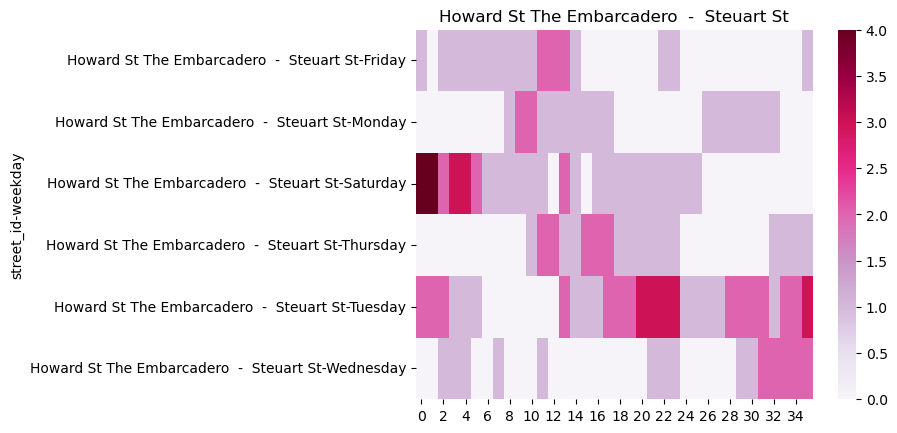

In [36]:
for street_id in df['street_id'].unique():
    slc = final_final_df.iloc[final_final_df.index.get_level_values('street_id') == street_id]
    sns.heatmap(slc, cmap = "PuRd").set(title=street_id)
    plt.show()

In [ ]:
def plot_dist(all_dists, street_id):
    temp_df = all_dists[all_dists.street_id == street_id]
    # has all 7 days of the week
    temp_df = temp_df[[col for col in temp_df.columns if col not in ['street_id', 'time_bin']]]
    temp_df.set_index('citation_day', inplace=True)
    sns.heatmap(temp_df, cmap = "PuRd").set(title=street_id)

plot_dist(all_dists, '43rd Ave Irving St  -  Judah St')

In [116]:
collapsed_df.groupby("street_id")["weekday"].value_counts()

street_id                            weekday  
01st St Clementina St  -  Folsom St  Monday       11
                                     Thursday     11
                                     Wednesday    11
                                     Friday       10
                                     Tuesday      10
                                                  ..
Zoe St Bryant St  -  Welsh St        Tuesday      16
                                     Wednesday    15
                                     Saturday     14
                                     Monday       13
                                     Sunday        1
Name: weekday, Length: 12228, dtype: int64

<Axes: ylabel='weekday'>

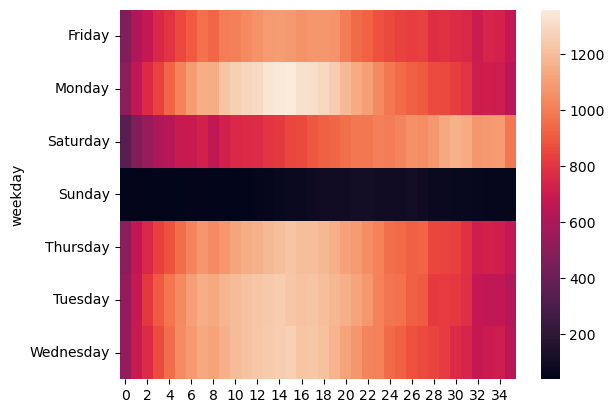

In [117]:
sns.heatmap(final_final_df[[col for col in final_final_df.columns if col != 'street_id']])

In [233]:
final_final_df.to_csv("../data/final_illegal.csv")

In [260]:
e_and_i = pd.read_csv("../data/prob_e_and_i.csv")

In [253]:
def flatten(l):
    return [item for sublist in l for item in sublist]

streets = flatten([[name]*7 for name in joined["street_id"].unique()])

In [254]:
arrays = [streets, ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]*len(joined["street_id"].unique())]

tuples = list(zip(*arrays))
new_idx = pd.MultiIndex.from_tuples(tuples, names=["streets", "days"])

In [266]:
e_and_i = e_and_i.rename(columns={"street_id": "streets", "citation_day": "days"}).set_index(['streets', 'days']).drop(['time_bin'], axis=1)

In [268]:
final_final_df = final_final_df.reindex(new_idx, fill_value=0)
e_and_i = e_and_i.reindex(new_idx, fill_value=0)

In [269]:
e_and_i = e_and_i.iloc[:, 12:48]


In [270]:
in_given_il = e_and_i.divide(final_final_df.values).fillna(0)
#(in_given_il.isnull()).sum().sum()
in_given_il

09:45:00  10:00:00  \
streets                                  days                            
Mission St 07th St  -  Julia St          Monday          0.0       0.0   
                                         Tuesday         0.0       0.0   
                                         Wednesday       0.0       inf   
                                         Thursday        0.0       0.0   
                                         Friday          0.0       0.0   
...                                                      ...       ...   
Sansome St Merchant St  -  Washington St Wednesday       0.0       0.0   
                                         Thursday        0.0       0.0   
                                         Friday          0.0       0.0   
                                         Saturday        0.0       0.0   
                                         Sunday          0.0       0.0   

                                                    10:15:00  10:30:00  \
streets                                  days                            
Mission St 07th St  -  Julia St          Monday          0.0       0.0   
                                         Tuesday         0.0       0.0   
                                         Wednesday       0.0       inf   
                                         Thursday        0.0       0.0   
                                         Friday          0.0       0.0   
...                                                      ...       ...   
Sansome St Merchant St  -  Washington St Wednesday       0.0       0.0   
                                         Thursday        0.0       0.0   
                                         Friday          0.0       0.0   
                                         Saturday        0.0       0.0   
                                         Sunday          0.0       0.0   

                                                    10:45:00  11:00:00  \
streets                                  days                            
Mission St 07th St  -  Julia St          Monday          0.0       0.0   
                                         Tuesday         0.0       0.0   
                                         Wednesday       0.0       0.0   
                                         Thursday        inf       0.0   
                                         Friday          0.0       0.0   
...                                                      ...       ...   
Sansome St Merchant St  -  Washington St Wednesday       0.0       0.0   
                                         Thursday        0.0       0.0   
                                         Friday          0.0       0.0   
                                         Saturday        0.0       0.0   
                                         Sunday          0.0       0.0   

                                                    11:15:00  11:30:00  \
streets                                  days                            
Mission St 07th St  -  Julia St          Monday          inf       0.0   
                                         Tuesday         0.0       0.0   
                                         Wednesday       0.0       0.0   
                                         Thursday        0.0       0.0   
                                         Friday          0.0       0.0   
...                                                      ...       ...   
Sansome St Merchant St  -  Washington St Wednesday       0.0       0.0   
                                         Thursday        0.0       0.0   
                                         Friday          0.0       0.0   
                                         Saturday        0.0       0.0   
                                         Sunday          0.0       0.0   

                                                    11:45:00  12:00:00  ...  \
streets                                  days                           ...   
Mission St 07th St  -  Julia St          M

In [271]:
in_given_il.sum().sum()

inf

<Axes: ylabel='streets-days'>

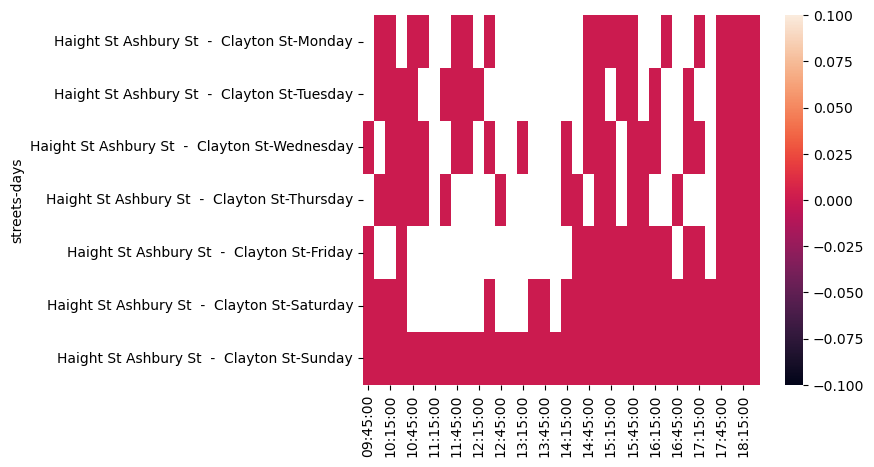

In [275]:
street_id = joined['street_id'].value_counts().index[111]
sns.heatmap(in_given_il.iloc[in_given_il.index.get_level_values('streets') == street_id])

In [193]:
in_given_il[in_given_il != 0]

09:00:00  09:15:00  09:30:00  \
streets                            days                                      
Mission St 07th St  -  Julia St    Monday            0         0         0   
                                   Tuesday           0         0         0   
                                   Wednesday         0         0         0   
                                   Thursday          0         0         0   
                                   Friday            0         0         0   
...                                                ...       ...       ...   
Webster St Union St  -  Filbert St Wednesday         0         0         0   
                                   Thursday          0         0         0   
                                   Friday            0         0         0   
                                   Saturday          0         0         0   
                                   Sunday            0         0         0   

                                              09:45:00  10:00:00  10:15:00  \
streets                            days                                      
Mission St 07th St  -  Julia St    Monday            0         0         0   
                                   Tuesday           0         0         0   
                                   Wednesday         0         0         0   
                                   Thursday          0         0         0   
                                   Friday            0         0         0   
...                                                ...       ...       ...   
Webster St Union St  -  Filbert St Wednesday         0         0         0   
                                   Thursday          0         0         0   
                                   Friday            0         0         0   
                                   Saturday          0         0         0   
                                   Sunday            0         0         0   

                                              10:30:00  10:45:00  11:00:00  \
streets                            days                                      
Mission St 07th St  -  Julia St    Monday            0         0         0   
                                   Tuesday           0         0         0   
                                   Wednesday         0         0         0   
                                   Thursday          0         0         0   
                                   Friday            0         0         0   
...                                                ...       ...       ...   
Webster St Union St  -  Filbert St Wednesday         0         0         0   
                                   Thursday          0         0         0   
                                   Friday            0         0         0   
                                   Saturday          0         0         0   
                                   Sunday            0         0         0   

                                              11:15:00  ...  15:30:00  \
streets                            days                 ...             
Mission St 07th St  -  Julia St    Monday            0  ...         0   
                                   Tuesday           0  ...         0   
                                   Wednesday         0  ...         0   
                                   Thursday          0  ...         0   
                                   Friday            0  ...         0   
...                                                ...  ...       ...   
Webster St Union St  -  Filbert St Wednesday         0  ...         0   
                                   Thursday          0  ...         0   
                                   Friday            0  ...         0   
                                   Saturday          0  ...         0   
                                   Sunday            0  ...         0   

                                              15:45